# Improving face match accuracy with Amazon Rekognition

In this lab we will see how creating collections with multiple profiles of faces leads to better face match accuracy than capturing a single face profile. In real life scenarios, selfies won't have great lighting or quality condition, which can affect face match accuracy. For this reason we encourage our customers to take multiple selfies, which will improve the accuracy. 

## Steps

These are the following steps we are going to accomplish:
- **Step 0 - Load libraries**
- **Step 1 - List existing collections**
- **Step 2 - Create collections**
- **Step 3 - Populate collections**
- **Step 4 - Compare faces against both collections**
- **Step 5 - Review results**
- **Step 6 - Clean up resources**

## Step 0 - Load libraries

In [2]:
!pip install -qU opencv-python-headless
import boto3, os, io, glob, cv2
import matplotlib.pyplot as plt
%matplotlib inline 
client=boto3.client('rekognition')


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


## Step 1 - List exisiting collections 

Before we create new collections, let's have a look if there are any exisiting collections in our account.

In [3]:
def list_collections():

    max_results=10
    
    print('Displaying collections...')
    response=client.list_collections(MaxResults=max_results)
    collection_count=0
    done=False
    
    while not done:
        collections=response['CollectionIds']

        for collection in collections:
            print (collection)
            collection_count+=1
        if 'NextToken' in response:
            nextToken=response['NextToken']
            response=client.list_collections(NextToken=nextToken,MaxResults=max_results)
            
        else:
            done=True

    return collection_count   

collection_count=list_collections()

print("There are: {} collections in your account ".format(collection_count))

Displaying collections...
There are: 0 collections in your account 


## Step 2 - Create new collections

In this section we will create two collections, in order to compare results when there is a single face in the collection versus multiple faces profiles.

In [4]:
collection_A='collectionA' # name your collection A
collection_B='collectionB' # name your collection B

def create_collection(collection_id):
    #Create a collection
    print('Creating collection:' + collection_id)
    try:
        response=client.create_collection(CollectionId=collection_id)
    except:
        client.delete_collection(CollectionId=collection_id)
        response=client.create_collection(CollectionId=collection_id)
    print('Collection ARN: ' + response['CollectionArn'])
    print('Status code: ' + str(response['StatusCode']))
    print('Done.')
    
create_collection(collection_A)
create_collection(collection_B)

Creating collection:collectionA
Collection ARN: aws:rekognition:eu-west-1:238023316787:collection/collectionA
Status code: 200
Done.
Creating collection:collectionB
Collection ARN: aws:rekognition:eu-west-1:238023316787:collection/collectionB
Status code: 200
Done.


### Step 2a - Confirm your collections creation.

In [5]:
collection_count=list_collections()
print("There are: {} collections in your account ".format(collection_count))

Displaying collections...
collectionA
collectionB
There are: 2 collections in your account 


## Step 3 - Populate collections 

### Step 3.a - Populate collection A

First we will index a single face into collection A. 

In [6]:
def populate_collection(collection, directory):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
            file = open(f, "rb") # opening for [r]eading as [b]inary
            data = file.read() 
            response=client.index_faces(CollectionId=collection,
                                Image={'Bytes':data},
                                ExternalImageId=f.split("/")[2],
                                MaxFaces=1,
                                QualityFilter="AUTO",
                                DetectionAttributes=['ALL'])
            print ('Results for ' + f.split("/")[2])
            print('Faces indexed:')
            for faceRecord in response['FaceRecords']:
                print('  Face ID : {}'.format( faceRecord['Face']['FaceId']))
                print('  Location: {}'.format(faceRecord['Face']['BoundingBox']))

            if len(response['UnindexedFaces']) > 0:
                print('Faces not indexed:')
                for unindexedFace in response['UnindexedFaces']:
                    print(' Location: {}'.format(unindexedFace['FaceDetail']['BoundingBox']))
                    print(' Reasons :')
                    for reason in unindexedFace['Reasons']:
                        print('   ' + reason)
            file.close()
    return

In [7]:
directory_A = 'media/single-profile'

In [8]:
populate_collection(collection_A,directory_A) 

media/single-profile/dani1.jpg
Results for dani1.jpg
Faces indexed:
  Face ID : 1b4f8cde-df13-4a84-9848-9f0866ea9c89
  Location: {'Width': 0.6322183609008789, 'Height': 0.5936641097068787, 'Left': 0.07803937792778015, 'Top': 0.13227343559265137}


Text(0.5, 1.0, 'dani1')

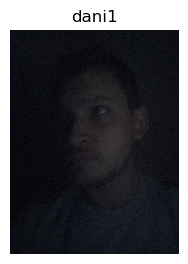

In [9]:
img = cv2.imread("media/single-profile/dani1.jpg")[:,:,::-1]
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 4, 1)
plt.imshow(img)
plt.axis('off')
plt.title("dani1")

### Step 3.b - Populate collection B

Now we will index multiple face profile populate B with multiple face profiles. Having multiple images of the same person should improve the face match results.

In [10]:
directory_B = 'media/multiple-profiles'

In [11]:
populate_collection(collection_B,directory_B) 

media/multiple-profiles/dani1.jpg
Results for dani1.jpg
Faces indexed:
  Face ID : a81a4ea3-8395-4230-bf03-1a3e48d3aa5f
  Location: {'Width': 0.5099508166313171, 'Height': 0.5418887138366699, 'Left': 0.2714802324771881, 'Top': 0.21852955222129822}
media/multiple-profiles/dani3.jpg
Results for dani3.jpg
Faces indexed:
  Face ID : 3b203a2c-04dc-44f3-a9d4-d678c5d06c85
  Location: {'Width': 0.6141138672828674, 'Height': 0.5431267023086548, 'Left': 0.12507522106170654, 'Top': 0.10763099789619446}
media/multiple-profiles/dani2.jpg
Results for dani2.jpg
Faces indexed:
  Face ID : 3c4894fb-ed01-4ff5-80cc-3dda5c8609d2
  Location: {'Width': 0.5996366739273071, 'Height': 0.580813467502594, 'Left': 0.12779802083969116, 'Top': 0.14054232835769653}
media/multiple-profiles/dani4.jpg
Results for dani4.jpg
Faces indexed:
  Face ID : d58a26d7-5705-4a05-a21d-7ed2f6a5a5cf
  Location: {'Width': 0.6733003258705139, 'Height': 0.623356282711029, 'Left': 0.07407209277153015, 'Top': 0.23582562804222107}


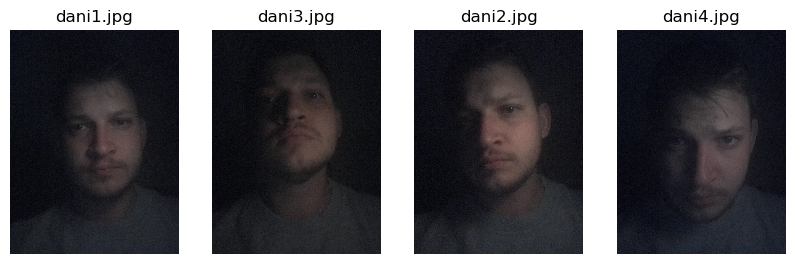

In [12]:
fig = plt.figure(figsize=(10, 7))
images = glob.glob("media/multiple-profiles/*.jpg")
for idx, image in enumerate(images):
    img = cv2.imread(image)[:,:,::-1]
    fig.add_subplot(1, len(images), idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image.split("/")[-1])

## Step 4 - Search faces against both collections

Now we have populated our collections, we will search the same photo against both collections to compare the similarity confidence in both cases.

Text(0.5, 1.0, 'test')

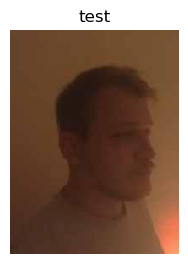

In [13]:
file = open("media/test-images/test1.jpg", "rb") # opening for [r]eading as [b]inary
data = file.read() 
img = cv2.imread("media/test-images/test1.jpg")[:,:,::-1]
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 4, 1)
plt.imshow(img)
plt.axis('off')
plt.title("test")

In [14]:
def search_face(data, collection):
    searchresults = client.search_faces_by_image(CollectionId=collection,
                                                    Image={'Bytes':data},
                                                    FaceMatchThreshold=50)
    return searchresults

In [15]:
searchA = search_face(data,collection_A)
searchB = search_face(data,collection_B)

## Step 5 - Review results

Let's have a look at the results of the search against collection A (one profile)

In [16]:
print(searchA)

{'SearchedFaceBoundingBox': {'Width': 0.432923823595047, 'Height': 0.4588027894496918, 'Left': 0.43703019618988037, 'Top': 0.2894178330898285}, 'SearchedFaceConfidence': 99.99383544921875, 'FaceMatches': [{'Similarity': 80.73101043701172, 'Face': {'FaceId': '1b4f8cde-df13-4a84-9848-9f0866ea9c89', 'BoundingBox': {'Width': 0.6322180032730103, 'Height': 0.5936639904975891, 'Left': 0.07803940027952194, 'Top': 0.13227300345897675}, 'ImageId': 'a297a66b-f12b-3d13-8e74-91bf2e376fe1', 'ExternalImageId': 'dani1.jpg', 'Confidence': 99.8635025024414, 'IndexFacesModelVersion': '6.0'}}], 'FaceModelVersion': '6.0', 'ResponseMetadata': {'RequestId': '7f5de567-a783-47e4-8f77-0de2b098df57', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7f5de567-a783-47e4-8f77-0de2b098df57', 'content-type': 'application/x-amz-json-1.1', 'content-length': '573', 'date': 'Thu, 20 Oct 2022 08:28:34 GMT'}, 'RetryAttempts': 0}}


Now let's see the results of the search against collection B (multiple profiles)

In [17]:
print(searchB)

{'SearchedFaceBoundingBox': {'Width': 0.432923823595047, 'Height': 0.4588027894496918, 'Left': 0.43703019618988037, 'Top': 0.2894178330898285}, 'SearchedFaceConfidence': 99.99383544921875, 'FaceMatches': [{'Similarity': 97.50440216064453, 'Face': {'FaceId': '3b203a2c-04dc-44f3-a9d4-d678c5d06c85', 'BoundingBox': {'Width': 0.614113986492157, 'Height': 0.5431270003318787, 'Left': 0.12507499754428864, 'Top': 0.10763099789619446}, 'ImageId': '53cfb2f7-2ede-3ffd-8655-7e83f326e34b', 'ExternalImageId': 'dani3.jpg', 'Confidence': 99.81170654296875, 'IndexFacesModelVersion': '6.0'}}, {'Similarity': 94.95133209228516, 'Face': {'FaceId': 'a81a4ea3-8395-4230-bf03-1a3e48d3aa5f', 'BoundingBox': {'Width': 0.5099509954452515, 'Height': 0.5418890118598938, 'Left': 0.271479994058609, 'Top': 0.21852999925613403}, 'ImageId': 'a8af6bca-d423-37f0-897a-59b4e71a5a7e', 'ExternalImageId': 'dani1.jpg', 'Confidence': 99.98410034179688, 'IndexFacesModelVersion': '6.0'}}, {'Similarity': 92.96436309814453, 'Face': {'

Let's compare the best similarities, when we use multiple profile pictures the face similarity score improves. 

In [18]:
print("Using a single face profile in a collection, the similarity score is {}".format(searchA["FaceMatches"][0]["Similarity"]))
print("Using multiple face profiles in a collection, the best similarity score is {}".format(searchB["FaceMatches"][0]["Similarity"]))

Using a single face profile in a collection, the similarity score is 80.73101043701172
Using multiple face profiles in a collection, the best similarity score is 97.50440216064453


## Step 6 - Clean up resources

Let's delete the collections we created in our account.

In [19]:
def delete_collection(collection_id):

    print('Attempting to delete collection ' + collection_id)
    status_code=0
    try:
        response=client.delete_collection(CollectionId=collection_id)
        status_code=response['StatusCode']
        
    except ClientError as e:
        if e.response['Error']['Code'] == 'ResourceNotFoundException':
            print ('The collection ' + collection_id + ' was not found ')
        else:
            print ('Error other than Not Found occurred: ' + e.response['Error']['Message'])
        status_code=e.response['ResponseMetadata']['HTTPStatusCode']
    print('Status code: ' + str(status_code))


delete_collection(collection_A)
delete_collection(collection_B)


Attempting to delete collection collectionA
Status code: 200
Attempting to delete collection collectionB
Status code: 200
